### esempio di lettura di un run di dati (6061) e uno di piedistalli (6060)


In [1]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy
import time
import pandas as pd

lettura info file dati:

In [2]:
df = cy.run_info_logbook(run=6061, sql=True, verbose=False)
df

,run_number,run_description,start_time,exposure_sec,GEM3_V,GEM2_V,GEM1_V,T2_V,T1_V,DRIFT_V,...,total_gas_flow,stop_time,number_of_events,storage_local_status,storage_cloud_status,storage_tape_status,file_size,file_checksum,file_s3_tag,online_reco_status
5508,6061,"S003:DATA:BKG, with pmt Trg: LVL2, 2mV thr, ve...",2022-12-03 07:24:11,0.3,420,420,420,500,500,960,...,NaN,2022-12-03 07:28:45,402.0,0,1,1,1668671789,6b820b7807bbc5f59dac3a418aaa0d37,LNGS,-1


In [3]:
print ("esempio di uso di un sigolo elementoi {:.2f}".format(df.GEM3_V.values[0]))


esempio di uso di un sigolo elementoi 420.00


lettura file dati, WARING: path e' dove si trova il file, cloud=False dice che il file vine letto in posix (quindi se si e' gia' sulla cloud va lasciato cosi) da remoto va messo cloud=True e il path diventa il luogo in cui il file vine scaricato e letto, se viene richimato lo stesso file dal path questo non vine piu' scaricato ma solamente letto 

In [4]:

mfile = cy.open_mid(run=12250, path='/s3/cygno-data/', cloud=False, tag='LNGS', verbose=False)

for event in mfile:
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

    for bank_name, bank in event.banks.items():
        if bank_name=='DGH0': # PMTs wavform 
            header = cy.daq_dgz_full2header(bank, verbose=False)
            waveform_f, waveform_s = cy.daq_dgz_full2array(event.banks['DIG0'], header)
        if bank_name=='CAM0': # CAM image
            image, _, _ = cy.daq_cam2array(bank) # matrice delle imagine

        if bank_name=='INPT': # SLOW channels array
            slow = cy.daq_slow2array(bank)
    if event.header.serial_number == 2: 
        break

Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1678380493 containing banks DMND, MSRD, CRNT, STAT, TPTR
2023-03-09 16:48:13, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1678380493 containing banks DMND, MSRD, CRNT, STAT, TPTR
2023-03-09 16:48:13, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1678380493 containing banks DMND, MSRD
2023-03-09 16:48:13, banks DMND, MSRD
Event # 0 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1678380493 containing banks DIG0, DGH0, CAM0
2023-03-09 16:48:13, banks DIG0, DGH0, CAM0
Event # 0 of type ID 7 contains banks TCAM
Received event with timestamp 1678380494 containing banks TCAM
2023-03-09 16:48:14, banks TCAM
Event # 1 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1678380

legge le waveforms (fino alla 5 perche' 5 ne acquisimo) e ne fa un plot

fa il plot dell'ultima imagine aperta (matrice image)

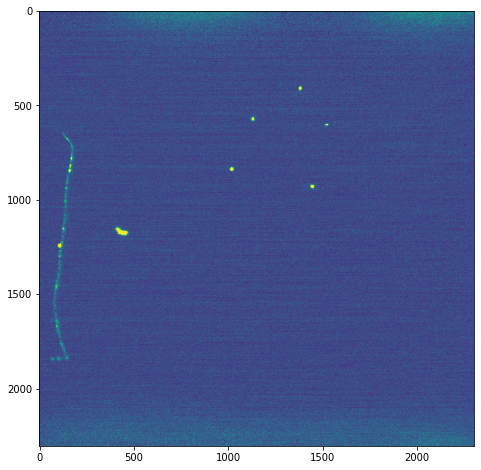

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(image, vmin=95, vmax=120)
plt.show()

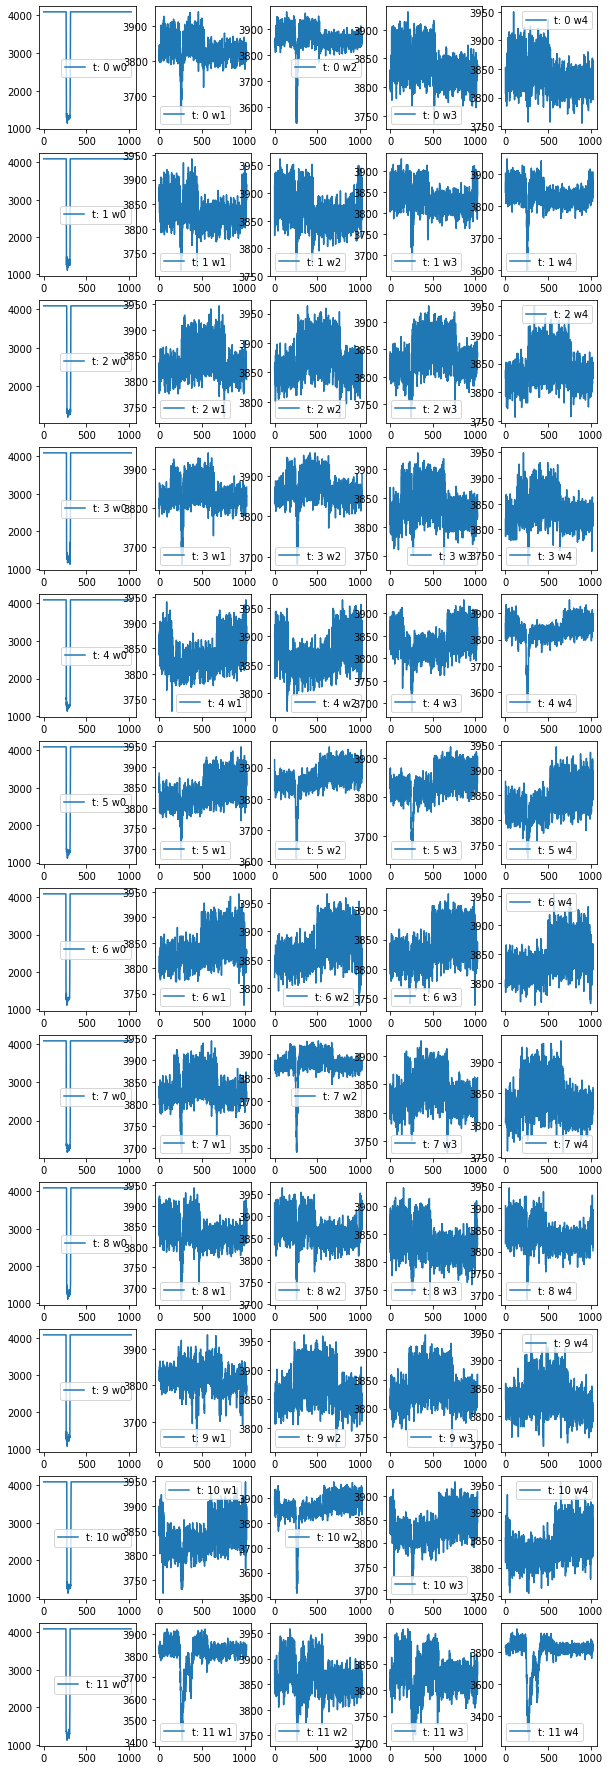

In [6]:
number_of_w_readed = 5
fig, ax = plt.subplots(header[0][0], number_of_w_readed, figsize=(10, header[1][0]))
for t in range(0, header[0][0]):
    offset = t*header[1][0]
    for w in range(0, number_of_w_readed):
        ax[t,w].plot(np.linspace(0, header[2][0], header[2][0]), waveform_f[offset], label="t: {:d} w{:d}".format(t,w))
        ax[t,w].legend()
        offset+=1

plt.show()

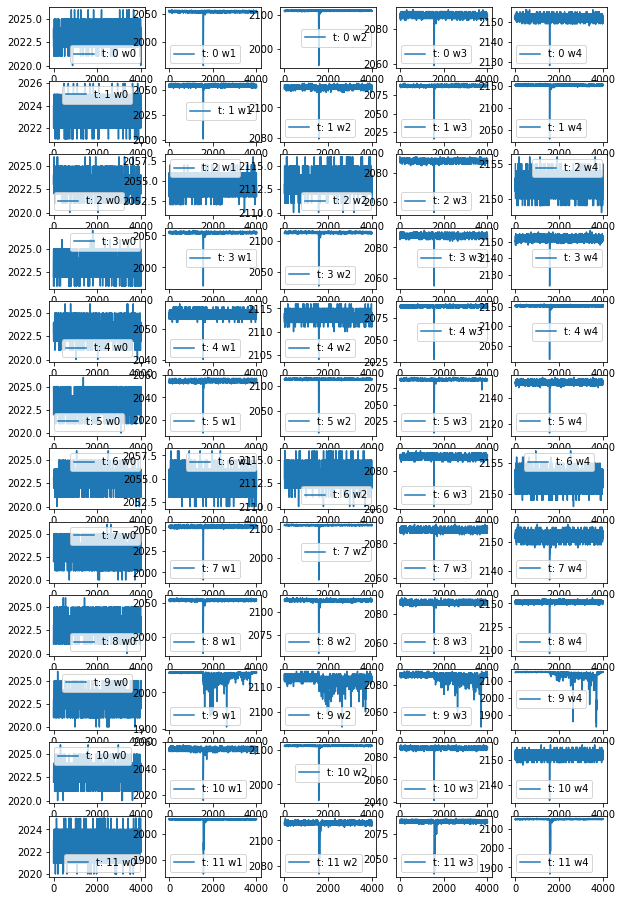

In [7]:
fig, ax = plt.subplots(header[0][1], number_of_w_readed, figsize=(10, 2*header[1][1]))
for t in range(0, header[0][1]):
    offset = t*header[1][1]
    for w in range(0, number_of_w_readed):
        ax[t,w].plot(np.linspace(0, header[2][1], header[2][1]), waveform_s[offset], label="t: {:d} w{:d}".format(t,w))
        ax[t,w].legend()
        offset+=1

plt.show()

stampa dal db sql le informazioni sul rum di pieditalli

In [9]:
df = cy.run_info_logbook(run=6766, sql=True, verbose=False)
df

,run_number,run_description,start_time,exposure_sec,GEM3_V,GEM2_V,GEM1_V,T2_V,T1_V,DRIFT_V,...,PMT4_V,HV_STATE,stop_time,number_of_events,storage_local_status,storage_cloud_status,storage_tape_status,file_size,file_checksum,file_s3_tag
6208,6766,"S003:PED:BKG, no PMT, flux 10l/h",2022-12-06 06:42:29,0.3,420,420,420,500,500,960,...,770,0,2022-12-06 06:43:23,101.0,1,1,1,364629681,7518b64a535ab9f4a3ceddabc7a71cf0,LNGS


la prossima funzione fa il piedistallo e la sigma di ogni run e li mette nella /tmp/ se vengono richiesti nuovamente questi vengono quindi letti dalla /tmp sennza rifare media e sigma

In [8]:
m_image, s_image = cy.ped_mid(run=6060, path_file='/s3/cygno-data/', path_ped='/tmp/', tag = 'LNGS', 
            cloud=False, verbose=True)

>>> Pedestal Maker! <<<
/run06060.mid.gz
/run06060.mid.gz
Debug Image[200,200]: 10 => 101.00 99.80 2.21
Debug Image[200,200]: 20 => 104.00 99.80 2.84
Debug Image[200,200]: 30 => 100.00 100.00 2.96
Debug Image[200,200]: 40 => 102.00 100.20 2.80
Debug Image[200,200]: 50 => 103.00 100.38 2.86
Debug Image[200,200]: 60 => 103.00 100.25 2.83
Debug Image[200,200]: 70 => 105.00 100.43 2.95
Debug Image[200,200]: 80 => 97.00 100.25 3.03
Debug Image[200,200]: 90 => 97.00 100.37 3.06
Debug Image[200,200]: 100 => 96.00 100.33 3.00
WRITING ...
DONE OUTPUT maen file: /tmp/mean_Run06060 sigma file: /tmp/sigma_Run06060


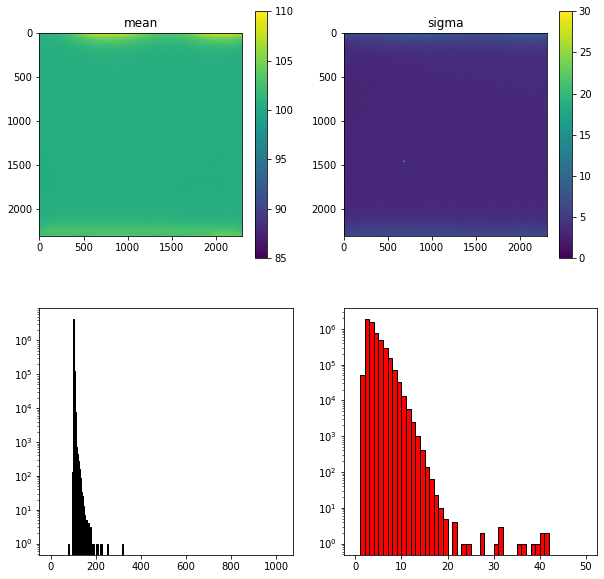

In [58]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
im = ax[0,0].imshow(m_image, vmin=85,vmax=110)
fig.colorbar(im, ax=ax[0, 0])
ax[0,0].set_title("mean")
ax[0,1].set_title("sigma")
im = ax[0, 1].imshow(s_image, vmin=0,vmax=30)
fig.colorbar(im, ax=ax[0,1])
ax[1,0].hist(m_image.ravel(), bins=256, range=(0.0, 1024.0), fc='b', ec='k')
ax[1,1].hist(s_image.ravel(), bins=50, range=(0.0, 50.0), fc='r', ec='k')
ax[1,0].set_yscale("log")
ax[1,1].set_yscale("log")

plt.show()

plot imagine con sottrazione del piedistallo

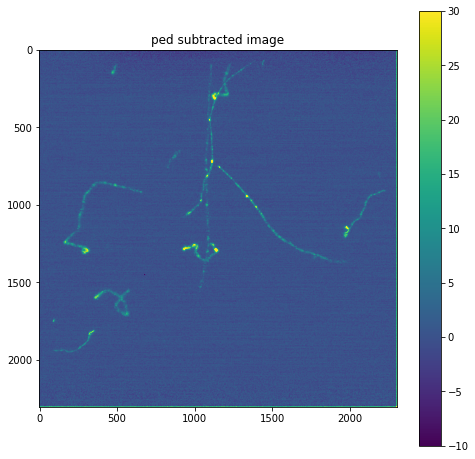

In [12]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(image-m_image, vmin=-10,vmax=30)
fig.colorbar(im, ax=ax)
ax.set_title("ped subtracted image")
plt.show()

In [7]:
m1_image, s1_image = cy.ped_mid(run=3961, path_file='/s3/cygno-data/', path_ped='/tmp/', tag = 'LNF', 
            cloud=True, verbose=True)

RELOAD maen file: /tmp/mean_Run03961 sigma file: /tmp/sigma_Run03961


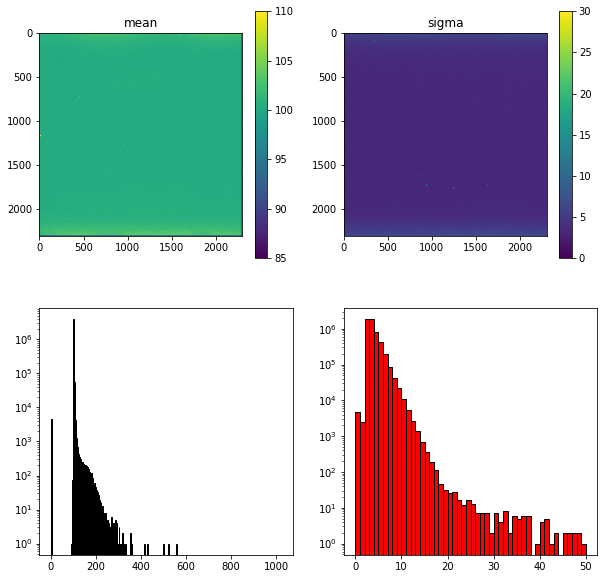

In [57]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
im = ax[0,0].imshow(m1_image, vmin=85,vmax=110)
fig.colorbar(im, ax=ax[0, 0])
ax[0,0].set_title("mean")
ax[0,1].set_title("sigma")
im = ax[0,1].imshow(s1_image, vmin=0,vmax=30)
fig.colorbar(im, ax=ax[0,1])
ax[1,0].hist(m1_image.ravel(), bins=256, range=(0.0, 1024.0), fc='b', ec='k')
ax[1,1].hist(s1_image.ravel(), bins=50, range=(0.0, 50.0), fc='r', ec='k')
ax[1,0].set_yscale("log")
ax[1,1].set_yscale("log")

plt.show()

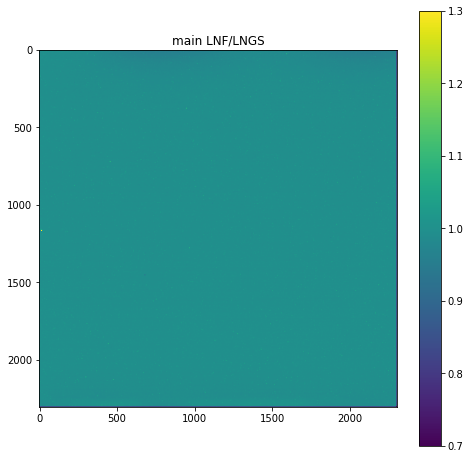

In [47]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(m1_image/m_image, vmin=0.7,vmax=1.3)
fig.colorbar(im, ax=ax)
ax.set_title("main LNF/LNGS")
plt.show()

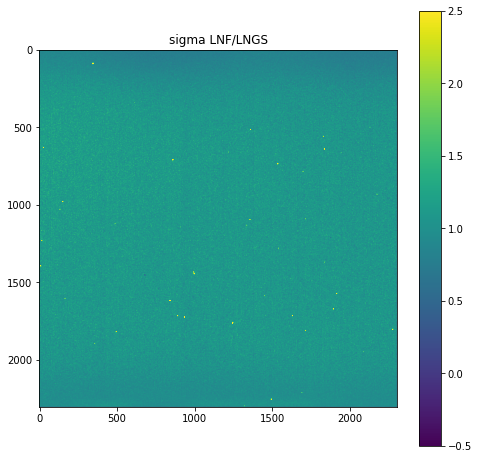

In [55]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(s1_image/s_image, vmin=-0.5,vmax=2.5)
fig.colorbar(im, ax=ax)
ax.set_title("sigma LNF/LNGS")
plt.show()

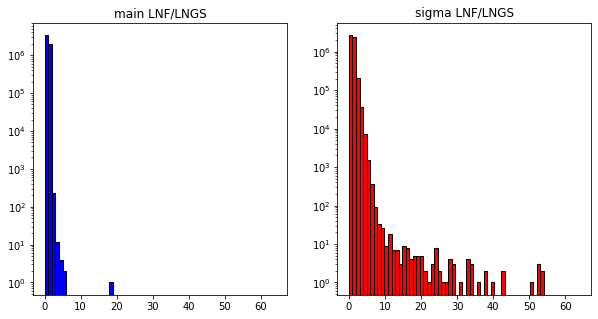

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist((m1_image/m_image).ravel(), bins=64, range=(0.0, 64.0), fc='b', ec='k')
ax[1].hist((s1_image/s_image).ravel(), bins=65, range=(0.0, 64.0), fc='r', ec='k')
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_title("main LNF/LNGS")
ax[1].set_title("sigma LNF/LNGS")
plt.show()

In [51]:
np.size(image), len(image)

(5308416, 2304)

In [53]:
nzero = round(image.mean())
z_image = image-nzero
z_image

array([[-10,   7,   2, ...,   2,  -3,   2],
       [  0,  -3,  -1, ...,   4,  -6,   1],
       [  3,  -1,  -7, ...,   0,  14,   4],
       ...,
       [ -5,   1,   1, ...,   1,   0,   5],
       [ -7,   1,   3, ...,   8,  -1,  -6],
       [  7,  -3,  11, ...,  -3,  12,   1]])

In [55]:
z_image[((z_image >0) | (z_image <0))]

array([-10,   7,   2, ...,  -3,  12,   1])

In [60]:
points = np.array(np.nonzero((z_image != 0))).T

In [61]:
np.size(points)

9348514

In [62]:
points

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [2303, 2301],
       [2303, 2302],
       [2303, 2303]])

In [64]:
np.save("./prova.img", image)

In [65]:
np.save("./prova.vet", points)

In [67]:
!ls -lh prova*

-rw-r--r-- 1 root root 41M Mar 19 10:41 prova.img.npy
-rw-r--r-- 1 root root 72M Mar 19 10:41 prova.vet.npy
